In [1]:
import datetime
#import gantt
from IPython.display import SVG

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
gantt.py - version and date, see below

This is a python class to create gantt chart using SVG


Author : Alexandre Norman - norman at xael.org

Contributors:

* Sébastien NOBILI - pipoprods at free.fr


Licence : GPL v3 or any later version


This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

"""

__author__ = 'Alexandre Norman (norman at xael.org)'
__version__ = '0.6.0'
__last_modification__ = '2016.03.20'

import codecs
import datetime
import logging
import sys
import types
import re

# https://bitbucket.org/mozman/svgwrite
# http://svgwrite.readthedocs.org/en/latest/

import svgwrite
# conversion from mm/cm to pixel is done by ourselve as firefox seems
# to have a bug for big numbers...
# 3.543307 is for conversion from mm to pt units !
mm = 3.543307
cm = 35.43307


# https://labix.org/python-dateutil
import dateutil.relativedelta

class x_scale:
    custom_x_scale = 1
    #Variable shared by inheritance with all other classes to define a custom x scaling
    def __init__(self):
        x_scale = ''
        while not (x_scale.isnumeric()):
            x_scale = input("Input x scale (1 is 100% x scaling)")
            custom_x_scale = float(x_scale)

class _my_svgwrite_drawing_wrapper(svgwrite.Drawing):
    """
    Hack for beeing able to use a file descriptor as filename
    """
    def save(self, width='100%', height='100%'):
        """ Write the XML string to **filename**. """
        test = False
        import io

        # Fix height and width
        self['height'] = height
        self['width'] = width
        
        if sys.version_info[0] == 2:
            test = type(self.filename) == types.FileType or type(self.filename) == types.InstanceType
        elif sys.version_info[0] == 3:
            test = type(self.filename) == io.TextIOWrapper

        if test:
            self.write(self.filename)
        else:
            fileobj = io.open(str(self.filename), mode='w', encoding='utf-8')
            self.write(fileobj)
            fileobj.close()



############################################################################

__LOG__ = None

############################################################################

DRAW_WITH_DAILY_SCALE = 'd'
DRAW_WITH_WEEKLY_SCALE = 'w'
DRAW_WITH_MONTHLY_SCALE = 'm'
DRAW_WITH_QUATERLY_SCALE = 'q'

############################################################################

# Unworked days (0: Monday ... 6: Sunday)
NOT_WORKED_DAYS = [5, 6]


def define_not_worked_days(list_of_days):
    """
    Define specific days off

    Keyword arguments:
    list_of_days -- list of integer (0: Monday ... 6: Sunday) - default [5, 6]
    """
    global NOT_WORKED_DAYS
    NOT_WORKED_DAYS = list_of_days
    return


def _not_worked_days():
    """
    Returns list of days off (0: Monday ... 6: Sunday)
    """
    global NOT_WORKED_DAYS
    return NOT_WORKED_DAYS


############################################################################

FONT_ATTR = {
    'fill': 'black',
    'stroke': 'black',
    'stroke_width': 0,
    'font_family': 'Verdana',
    'font_size': 15
    }


def define_font_attributes(fill='black', stroke='black', stroke_width=0, font_family="Verdana"):
    """
    Define font attributes
    
    Keyword arguments:
    fill -- fill - default 'black'
    stroke -- stroke - default 'black'
    stroke_width -- stroke width - default 0
    font_family -- font family - default 'Verdana'
    """
    global FONT_ATTR

    FONT_ATTR = {
        'fill': fill,
        'stroke' : stroke,
        'stroke_width': stroke_width,
        'font_family': font_family, 
        }

    return


def _font_attributes():
    """
    Return dictionnary of font attributes
    Example :
    FONT_ATTR = {
      'fill': 'black',
      'stroke': 'black',
      'stroke_width': 0,
      'font_family': 'Verdana',
    }
    """
    global FONT_ATTR
    return FONT_ATTR


############################################################################


# list of vacations as datetime (non worked days)
VACATIONS = []


############################################################################


def add_vacations(start_date, end_date=None):
    """
    Add vacations to a resource begining at [start_date] to [end_date]
    (included). If [end_date] is not defined, vacation will be for [start_date]
    day only

    Keyword arguments:
    start_date -- datetime.date begining of vacation
    end_date -- datetime.date end of vacation of vacation
    """
    __LOG__.debug('** add_vacations {0}'.format({'start_date':start_date, 'end_date':end_date}))

    global VACATIONS
    
    if end_date is None:
        if start_date not in VACATIONS:
            VACATIONS.append(start_date)
    else:
        while start_date <= end_date:
            if start_date not in VACATIONS:
                VACATIONS.append(start_date)
                
            start_date += datetime.timedelta(days=1)

    __LOG__.debug('** add_vacations {0}'.format({'start_date':start_date, 'end_date':end_date, 'vac':VACATIONS}))

    return

############################################################################

def init_log_to_sysout(level=logging.INFO):
    """
    Init global variable __LOG__ used for logging purpose

    Keyword arguments:
    level -- logging level (from logging.debug to logging.critical)
    """
    global __LOG__
    logger = logging.getLogger("Gantt")
    logger.setLevel(level)
    fh = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    __LOG__ = logging.getLogger("Gantt")
    return

############################################################################

def _show_version(name, **kwargs):
    """
    Show version
    """
    import os
    print("{0} version {1}".format(os.path.basename(name), __version__))
    return True


############################################################################


def _flatten(l, ltypes=(list, tuple)):
    """
    Return a flatten list from a list like [1,2,[4,5,1]]
    """
    ltype = type(l)
    l = list(l)
    i = 0
    while i < len(l):
        while isinstance(l[i], ltypes):
            if not l[i]:
                l.pop(i)
                i -= 1
                break
            else:
                l[i:i + 1] = l[i]
        i += 1
    return ltype(l)

############################################################################
class GroupOfResources(object):
    """
    Class for grouping resources
    """
    def __init__(self, name, fullname=None):
        """
        Init a group of resource resource

        Keyword arguments:
        name -- name given to the resource (id)
        fullname -- long name given to the resource
        """
        __LOG__.debug('** GroupOfResources::__init__ {0}'.format({'name':name}))
        self.name = name
        self.vacations = []
        if fullname is not None:
            self.fullname = fullname
        else:
            self.fullname = name

        self.resources = []

        self.tasks = []
        return

    def add_resource(self, resource):
        """
        Add a resource to the group of resources

        Keyword arguments:
        resource -- Resource object
        """
        if resource not in self.resources:
            self.resources.append(resource)
            resource.add_group(self)
        return


    def add_vacations(self, dfrom, dto=None):
        """
        Add vacations to a resource begining at [dfrom] to [dto] (included). If
        [dto] is not defined, vacation will be for [dfrom] day only

        Keyword arguments:
        dfrom -- datetime.date begining of vacation
        dto -- datetime.date end of vacation of vacation
        """
        __LOG__.debug('** Resource::add_vacations {0}'.format({'name':self.name, 'dfrom':dfrom, 'dto':dto}))
        if dto is None:
            self.vacations.append((dfrom, dfrom))
        else:
            self.vacations.append((dfrom, dto))
        return



    def nb_elements(self):
        """
        Returns the number of resources
        """
        __LOG__.debug('** GroupOfResources::nb_elements ({0})'.format({'name':self.name}))
        return len(self.resources)



    def is_available(self, date):
        """
        Returns True if any resource is available at given date, False if not.
        Availibility is taken from the global VACATIONS and resource's ones.

        Keyword arguments:
        date -- datetime.date day to look for
        """
        # Global VACATIONS
        if date in VACATIONS:
            __LOG__.debug('** GroupOfResources::is_available {0} : False (global vacation)'.format({'name':self.name, 'date':date}))
            return False

        # Group vacations
        for h in self.vacations:
            dfrom, dto = h
            if date >= dfrom and date <= dto:
                __LOG__.debug('** GroupOfResources::is_available {0} : False (group vacation)'.format({'name':self.name, 'date':date}))
                return False

        # Test if at least one resource is avalaible
        for r in self.resources:
            if r.is_available(date):
                __LOG__.debug('** GroupOfResources::is_available {0} : True {1}'.format({'name':self.name, 'date':date}, r.name))
                return True

        __LOG__.debug('** GroupOfResources::is_available {0} : False'.format({'name':self.name, 'date':date}))
        return False


    def add_task(self, task):
        """
        Tell the resource that we have assigned a task

        Keyword arguments:
        task -- Task object
        """
        if task not in self.tasks:
            self.tasks.append(task)
        return


    def search_for_task_conflicts(self, all_tasks = False):
        """
        Returns a dictionnary of all days (datetime.date) containing for each
        overcharged day the list of task for this day.

        It examines all resources member and group tasks.

        Keyword arguments:
        all_tasks -- if True return all tasks for all days, not just overcharged days
        """
        # Get for each resource
        affected_days = {}
        for r in self.resources:
            ad = r.search_for_task_conflicts(all_tasks = True)
            for d in ad:
                try:
                    affected_days[d].append(ad[d])
                except KeyError:
                    affected_days[d] = [ ad[d] ]

        # inspect project
        for t in self.tasks:
            cday = t.start_date()
            while cday <= t.end_date():
                if cday.weekday() not in _not_worked_days():
                    try:
                        affected_days[cday].append(t.fullname)
                    except KeyError:
                        affected_days[cday] = [t.fullname]
                  
                cday += datetime.timedelta(days=1)


        # compile everything
        overcharged_days = {}
        ke = list(affected_days.keys())
        ke.sort()
        for d in ke:
            affected_days[d] = _flatten(affected_days[d])
            if all_tasks:
                overcharged_days[d] = affected_days[d]

            elif len(affected_days[d]) > self.nb_elements():
                overcharged_days[d] = affected_days[d]
                __LOG__.warning('** GroupOfResources "{2}" has more than {3} tasks on day {0} / {1}'.format(d, affected_days[d], self.name, self.nb_elements()))
                
        return overcharged_days



    def is_vacant(self, from_date, to_date):
        """
        Check if any resource from the group is unallocated between for a given timeframe.
        Returns a list of available ressource name.
        
        Keyword arguments:
        from_date -- first day
        to_date --  last day
        """
        availables = []
        for r in self.resources:
            if len(r.is_vacant(from_date, to_date)) >0:
                availables.append(r.name)
                
        return availables


############################################################################

class Resource(object):
    """
    Class for handling resources assigned to tasks
    """
    def __init__(self, name, fullname=None):
        """
        Init a resource

        Keyword arguments:
        name -- name given to the resource (id)
        fullname -- long name given to the resource
        """
        __LOG__.debug('** Resource::__init__ {0}'.format({'name':name}))
        self.name = name
        if fullname is not None:
            self.fullname = fullname
        else:
            self.fullname = name

        self.vacations = []
        self.member_of_groups = []

        self.tasks = []
        return

    def add_vacations(self, dfrom, dto=None):
        """
        Add vacations to a resource begining at [dfrom] to [dto] (included). If
        [dto] is not defined, vacation will be for [dfrom] day only

        Keyword arguments:
        dfrom -- datetime.date begining of vacation
        dto -- datetime.date end of vacation of vacation
        """
        __LOG__.debug('** Resource::add_vacations {0}'.format({'name':self.name, 'dfrom':dfrom, 'dto':dto}))
        if dto is None:
            self.vacations.append((dfrom, dfrom))
        else:
            self.vacations.append((dfrom, dto))
        return


    def nb_elements(self):
        """
        Returns the number of resources, 1 here
        """
        __LOG__.debug('** Resource::nb_elements ({0})'.format({'name':self.name}))
        return 1


    def is_available(self, date):
        """
        Returns True if the resource is available at given date, False if not.
        Availibility is taken from the global VACATIONS and resource's ones.

        Keyword arguments:
        date -- datetime.date day to look for
        """
        # global VACATIONS
        if date in VACATIONS:
            __LOG__.debug('** Resource::is_available {0} : False (global vacation)'.format({'name':self.name, 'date':date}))
            return False
        
        # GroupOfResources vacation
        for g in self.member_of_groups:
            for h in g.vacations:
                dfrom, dto = h
                if date >= dfrom and date <= dto:
                    __LOG__.debug('** Resource::is_available {0} : False (Group {1})'.format({'name':self.name, 'date':date}, g.name))
                    return False
        

        # Resource vacation
        for h in self.vacations:
            dfrom, dto = h
            if date >= dfrom and date <= dto:
                __LOG__.debug('** Resource::is_available {0} : False'.format({'name':self.name, 'date':date}))
                return False
        __LOG__.debug('** Resource::is_available {0} : True'.format({'name':self.name, 'date':date}))
        return True


    def add_group(self, groupofresources):
        """
        Tell the resource it belongs to a GroupOfResources
        
        Keyword arguments:
        groupofresources -- GroupOfResources
        """
        if groupofresources not in self.member_of_groups:
            self.member_of_groups.append(groupofresources)
        return


    def add_task(self, task):
        """
        Tell the resource that we have assigned a task

        Keyword arguments:
        task -- Task object
        """
        if task not in self.tasks:
            self.tasks.append(task)
        return


    def search_for_task_conflicts(self, all_tasks=False):
        """
        Returns a dictionnary of all days (datetime.date) containing for each
        overcharged day the list of task for this day.

        Keyword arguments:
        all_tasks -- if True return all tasks for all days, not just overcharged days
        """
        affected_days = {}
        for t in self.tasks:
            cday = t.start_date()
            while cday <= t.end_date():
                if cday.weekday() not in _not_worked_days():
                    try:
                        affected_days[cday].append(t.fullname)
                    except KeyError:
                        affected_days[cday] = [t.fullname]
                    
                cday += datetime.timedelta(days=1)

        # return all
        if all_tasks:
            return affected_days

        # compile only overcharge
        overcharged_days = {}
        ke = list(affected_days.keys())
        ke.sort()
        for d in ke:
            if len(affected_days[d]) > 1:
                overcharged_days[d] = affected_days[d]
                __LOG__.warning('** Resource "{2}" has more than one task on day {0} / {1}'.format(d, affected_days[d], self.name))
                
        return overcharged_days
            


    def is_vacant(self, from_date, to_date):
        """
        Check if the resource is unallocated between for a given timeframe.
        Returns True if the resource is free, False otherwise
        
        Keyword arguments:
        from_date -- first day
        to_date --  last day
        """
        non_vacant_days = self.search_for_task_conflicts(all_tasks=True)
        cday = from_date
        while cday <= to_date:
            if cday.weekday() not in _not_worked_days():
                if not self.is_available(cday):
                    __LOG__.debug('** Ressource "{0}" is not available on day {1} (vacation)'.format(self.name, cday))
                    return []
                if cday in non_vacant_days:
                    __LOG__.debug('** Ressource "{0}" is not available on day {1} (other task : {2})'.format(self.name, cday, non_vacant_days[cday]))
                    return []

            cday += datetime.timedelta(days=1)
        return [self.name]

############################################################################


class Task(x_scale):
    """
    Class for manipulating Tasks
    """
    def __init__(self, name, start=None, stop=None, duration=None, depends_of=None, resources=None, percent_done=0, color=None, fullname=None, display=True, state=''):
        """
        Initialize task object. Two of start, stop or duration may be given.
        This task can rely on other task and will be completed with resources.
        If percent done is given, a progress bar will be included on the task.
        If color is specified, it will be used for the task.

        Keyword arguments:
        name -- name of the task (id)
        fullname -- long name given to the resource
        start -- datetime.date, first day of the task, default None
        stop -- datetime.date, last day of the task, default None
        duration -- int, duration of the task, default None
        depends_of -- list of Task which are parents of this one, default None
        resources -- list of Resources assigned to the task, default None
        percent_done -- int, percent of achievment, default 0
        color -- string, html color, default None
        display -- boolean, display this task, default True
        state -- string, state of the task
        """

        
        __LOG__.debug('** Task::__init__ {0}'.format({'name':name, 'start':start, 'stop':stop, 'duration':duration, 'depends_of':depends_of, 'resources':resources, 'percent_done':percent_done}))
        self.name = name
        if fullname is not None:
            self.fullname = fullname
        else:
            self.fullname = name

        self.start = start
        self.stop = stop
        self.duration = duration
        self.color = color
        self.display = display
        self.state = state

        ends = (self.start, self.stop, self.duration)
        nonecount = 0
        for e in ends:
            if e is None:
                nonecount += 1

        # check limits (2 must be set on 4) or scheduling is defined by duration and dependencies
        if nonecount != 1 and  (self.duration is None or depends_of is None):
            __LOG__.error('** Task "{1}" must be defined by two of three limits ({0})'.format({'start':self.start, 'stop':self.stop, 'duration':self.duration}, fullname))
            # Bug ? may be defined later
            #raise ValueError('Task "{1}" must be defined by two of three limits ({0})'.format({'start':self.start, 'stop':self.stop, 'duration':self.duration}, fullname))

        if type(depends_of) is type([]):
            self.depends_of = depends_of
        elif depends_of is not None:
            self.depends_of = [depends_of]
        else:
            self.depends_of = None

        self.resources = resources
        self.percent_done = percent_done
        self.drawn_x_begin_coord = None
        self.drawn_x_end_coord = None
        self.drawn_y_coord = None
        self._cache_start_date = None
        self._cache_end_date = None

        # tell each resource we have
        # assigned a new task
        if resources is not None:
            for r in resources:
                r.add_task(self)

        return


    def add_depends(self, depends_of):
        """
        Adds dependency to a task

        Keyword arguments:
        depends_of -- list of Task which are parents of this one
        """
        if type(depends_of) is type([]):
            if self.depends_of is None:
                self.depends_of = depends_of
            else:
                for d in depends_of:
                    self.depends_of.append(d)
        else:
            if self.depends_of is None:
                self.depends_of = depends_of
            else:
                self.depends_of.append(depends_of)

        return


    def start_date(self):
        """
        Returns the first day of the task, either the one which was given at
        task creation or the one calculated after checking dependencies
        """
        if self._cache_start_date is not None:
            return self._cache_start_date

        __LOG__.debug('** Task::start_date ({0})'.format(self.name))
        if self.start is not None:
            # start date setted, calculate begining
            if self.depends_of is None:
                # depends of nothing... start date is start
                #__LOG__.debug('*** Do not depend of other task')
                start = self.start
                while start.weekday() in _not_worked_days() or start in VACATIONS:
                    start = start + datetime.timedelta(days=1)

                if start > self.start:
                    __LOG__.warning('** Due to vacations, Task "{0}", will not start on date {1} but {2}'.format(self.fullname, self.start, start))

                self._cache_start_date = start
                return self._cache_start_date
            else:
                # depends of other task, start date could vary
                #__LOG__.debug('*** Do depend of other tasks')
                start = self.start
                while start.weekday() in _not_worked_days() or start in VACATIONS:
                    start = start + datetime.timedelta(days=1)

                prev_task_end = start
                for t in self.depends_of:
                    if isinstance(t, Milestone):
                        if t.end_date() >= prev_task_end:
                            prev_task_end = t.end_date()
                    elif isinstance(t, Task):
                        if t.end_date() >= prev_task_end:
                            prev_task_end = t.end_date() + datetime.timedelta(days=1)

                while prev_task_end.weekday() in _not_worked_days() or prev_task_end in VACATIONS:
                    prev_task_end = prev_task_end + datetime.timedelta(days=1)

                if prev_task_end > self.start:
                    __LOG__.warning('** Due to dependencies, Task "{0}", will not start on date {1} but {2}'.format(self.fullname, self.start, prev_task_end))

                self._cache_start_date = prev_task_end
                return self._cache_start_date

        elif self.duration is None: # start and stop fixed
            current_day = self.start
            # check depends
            if self.depends_of is not None:
                prev_task_end = self.depends_of[0].end_date()
                for t in self.depends_of:
                    if isinstance(t, Milestone):
                        if t.end_date() > prev_task_end:
                            prev_task_end = t.end_date() - datetime.timedelta(days=1)
                    elif isinstance(t, Task):
                        if t.end_date() > prev_task_end:
                            prev_task_end = t.end_date()
                    # if t.end_date() > prev_task_end:
                    #     #__LOG__.debug('*** latest one {0} which end on {1}'.format(t.name, t.end_date()))
                    #     prev_task_end = t.end_date()
                if prev_task_end > current_day:
                    depend_start_date = prev_task_end
                else:
                    start = self.start
                    while start.weekday() in _not_worked_days() or start in VACATIONS:
                        start = start + datetime.timedelta(days=1)
                    depend_start_date = start

                    if depend_start_date > current_day:
                        __LOG__.error('** Due to dependencies, Task "{0}", could not be finished on time (should start as last on {1} but will start on {2})'.format(self.fullname, current_day, depend_start_date))
                    self._cache_start_date = depend_start_date           
            else:
                # should be first day of start...
                self._cache_start_date = current_day            

            return self._cache_start_date

        elif self.duration is not None and self.depends_of is not None and self.stop is None :  # duration and dependencies fixed
            prev_task_end = self.depends_of[0].end_date()
            for t in self.depends_of:
                if isinstance(t, Milestone):
                    if t.end_date() > prev_task_end:
                        prev_task_end = t.end_date() - datetime.timedelta(days=1)
                elif isinstance(t, Task):
                    if t.end_date() > prev_task_end:
                        prev_task_end = t.end_date()
                # if t.end_date() > prev_task_end:
                #     __LOG__.debug('*** latest one {0} which end on {1}'.format(t.name, t.end_date()))
                #     prev_task_end = t.end_date()

            start = prev_task_end + datetime.timedelta(days=1)
            
            while start.weekday() in _not_worked_days() or start in VACATIONS:
                start = start + datetime.timedelta(days=1)

            # should be first day of start...
            self._cache_start_date = start

        elif self.start is None and self.stop is not None: # stop and duration fixed
            # start date not setted, calculate from end_date + depends
            current_day = self.stop
            real_duration = 0
            duration = self.duration 
            while duration > 0:
                if not (current_day.weekday() in _not_worked_days() or current_day in VACATIONS):
                    real_duration = real_duration + 1
                    duration -= 1
                else:
                    real_duration = real_duration + 1

                current_day = self.stop - datetime.timedelta(days=real_duration)
            current_day = self.stop - datetime.timedelta(days=real_duration - 1)

            # check depends
            if self.depends_of is not None:
                prev_task_end = self.depends_of[0].end_date()
                for t in self.depends_of:
                    if isinstance(t, Milestone):
                        if t.end_date() > prev_task_end:
                            prev_task_end = t.end_date()
                    elif isinstance(t, Task):
                        if t.end_date() > prev_task_end:
                            prev_task_end = t.end_date()
                    # if t.end_date() > prev_task_end:
                    #     __LOG__.debug('*** latest one {0} which end on {1}'.format(t.name, t.end_date()))
                    #     prev_task_end = t.end_date()

                if prev_task_end > current_day:
                    start = prev_task_end + datetime.timedelta(days=1)
                    #return prev_task_end
                else:
                    start = current_day

                
                while start.weekday() in _not_worked_days() or start in VACATIONS:
                    start = start + datetime.timedelta(days=1)

                depend_start_date = start

                if depend_start_date > current_day:
                    __LOG__.error('** Due to dependencies, Task "{0}", could not be finished on time (should start as last on {1} but will start on {2})'.format(self.fullname, current_day, depend_start_date))
                    self._cache_start_date = depend_start_date           
                else:
                    # should be first day of start...
                    self._cache_start_date = depend_start_date
            else:
                # should be first day of start...
                self._cache_start_date = current_day            


        if self._cache_start_date != self.start:
            __LOG__.warning('** starting date for task "{0}" is changed from {1} to {2}'.format(self.fullname, self.start, self._cache_start_date))
        return self._cache_start_date


    def end_date(self):
        """
        Returns the last day of the task, either the one which was given at task
        creation or the one calculated after checking dependencies
        """
        # Should take care of resources vacations ?
        if self._cache_end_date is not None:
            return self._cache_end_date

        __LOG__.debug('** Task::end_date ({0})'.format(self.name))

        if self.duration is None or self.start is None and self.stop is not None:
            real_end = self.stop
            # Take care of vacations
            while real_end.weekday() in _not_worked_days() or real_end in VACATIONS:
                real_end -= datetime.timedelta(days=1)

            if real_end <= self.start_date():
                current_day = self.start_date()
                real_duration = 0
                duration = self.duration   
                while duration > 1 or (current_day.weekday() in _not_worked_days() or current_day in VACATIONS):
                    if not (current_day.weekday() in _not_worked_days() or current_day in VACATIONS):
                        real_duration = real_duration + 1
                        duration -= 1
                    else:
                        real_duration = real_duration + 1
        
                    current_day = self.start_date() + datetime.timedelta(days=real_duration)
        
                self._cache_end_date = self.start_date() + datetime.timedelta(days=real_duration)
                __LOG__.warning('** task "{0}" will not be finished on time : end_date is changed from {1} to {2}'.format(self.fullname, self.stop, self._cache_end_date))
                return self._cache_end_date
                    

            self._cache_end_date = real_end
            if real_end != self.stop:
                __LOG__.warning('** task "{0}" will not be finished on time : end_date is changed from {1} to {2}'.format(self.fullname, self.stop, self._cache_end_date))


                
            return self._cache_end_date

        if self.stop is None:
            current_day = self.start_date()
            real_duration = 0
            duration = self.duration   
            while duration > 1 or (current_day.weekday() in _not_worked_days() or current_day in VACATIONS):
                if not (current_day.weekday() in _not_worked_days() or current_day in VACATIONS):
                    real_duration = real_duration + 1
                    duration -= 1
                else:
                    real_duration = real_duration + 1
    
                current_day = self.start_date() + datetime.timedelta(days=real_duration)
    
            self._cache_end_date = self.start_date() + datetime.timedelta(days=real_duration)
            return self._cache_end_date

        raise(ValueError)
        return None

    def svg(self, prev_y=0, start=None, end=None, color=None, level=None, scale=DRAW_WITH_DAILY_SCALE, title_align_on_left=False, offset=0):
        """
        Return SVG for drawing this task.

        Keyword arguments:
        prev_y -- int, line to start to draw
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        color -- string of color for drawing the project
        level -- int, indentation level of the project, not used here
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        title_align_on_left -- boolean, align task title on left
        offset -- X offset from image border to start of drawing zone
        """
        __LOG__.debug('** Task::svg ({0})'.format({'name':self.name, 'prev_y':prev_y, 'start':start, 'end':end, 'color':color, 'level':level}))

        if not self.display:
            __LOG__.debug('** Task::svg ({0}) display off'.format({'name':self.name}))
            return(None, 0)

        add_modified_begin_mark = False
        add_modified_end_mark = False

        if start is None:
            start = self.start_date()

        if self.start is not None and self.start_date() != self.start:
            add_modified_begin_mark = True

        if end is None:
            end = self.end_date()

        if self.stop is not None and self.end_date() != self.stop:
            add_modified_end_mark = True

        # override project color if defined
        if self.color is not None:
            color = self.color

        add_begin_mark = False
        add_end_mark = False

        y = prev_y * 10


        if scale == DRAW_WITH_DAILY_SCALE:
            def _time_diff(e, s):
                return (e - s).days
            def _time_diff_d(e, s):
                return _time_diff(e, s) + 1

        elif scale == DRAW_WITH_WEEKLY_SCALE:
            def _time_diff(end_date, start_date):
                td = 0
                guess = start_date
                while guess.weekday() != 0:
                    guess = guess + dateutil.relativedelta.relativedelta(days=-1)

                while end_date.weekday() != 6:
                    end_date = end_date + dateutil.relativedelta.relativedelta(days=+1)
                    
                while guess + dateutil.relativedelta.relativedelta(days=+6) < end_date:
                    td += 1
                    guess = guess + dateutil.relativedelta.relativedelta(weeks=+1)

                return td 
            def _time_diff_d(e, s):
                return _time_diff(e, s) + 1

        elif scale == DRAW_WITH_MONTHLY_SCALE:
            def _time_diff(end_date, start_date):
                return dateutil.relativedelta.relativedelta(end_date, start_date).months + dateutil.relativedelta.relativedelta(end_date, start_date).years*12
            def _time_diff_d(e, s):
                return _time_diff(e, s) + 1


        elif scale == DRAW_WITH_QUATERLY_SCALE:
            __LOG__.critical('DRAW_WITH_QUATERLY_SCALE not implemented yet')
            sys.exit(1)


        # cas 1 -s--S==E--e-
        if self.start_date() >= start and self.end_date() <= end:
            x = _time_diff(self.start_date(), start) * 10 
            d = _time_diff_d(self.end_date(), self.start_date()) * 10 
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
        # cas 5 -s--e--S==E-
        elif self.start_date() > end:
            return (None, 0)
        # cas 6 -S==E-s--e-
        elif self.end_date() < start:
            return (None, 0)
        # cas 2 -S==s==E--e-
        elif self.start_date() < start and self.end_date() <= end:
            x = 0
            d = _time_diff_d(self.end_date(), start) * 10 
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
            add_begin_mark = True
        # cas 3 -s--S==e==E-
        elif self.start_date() >= start and  self.end_date() > end:
            x = _time_diff(self.start_date(), start) * 10 
            d = _time_diff_d(end, self.start_date()) * 10 
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
            add_end_mark = True
        # cas 4 -S==s==e==E-
        elif self.start_date() < start and self.end_date() > end:
            x = 0
            d = _time_diff_d(end, start) * 10 
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x+d
            add_end_mark = True
            add_begin_mark = True
        else:
            return (None, 0)    


        self.drawn_y_coord = y
        

        svg = svgwrite.container.Group(id=re.sub(r"[ ,'\/()]", '_', self.name))
        svg.add(svgwrite.shapes.Rect(
                insert=((x+1+offset)*mm * x_scale.custom_x_scale, (y+1)*mm),
                size=((d-2)*mm * x_scale.custom_x_scale, 8*mm),
                fill=color,
                stroke=color,
                stroke_width=2,
                opacity=0.85,
                ))
        svg.add(svgwrite.shapes.Rect(
                insert=((x+1+offset)*mm * x_scale.custom_x_scale, (y+6)*mm),
                size=(((d-2))*mm * x_scale.custom_x_scale, 3*mm),
                fill="#909090",
                stroke=color,
                stroke_width=1,
                opacity=0.2,
                ))

        if add_modified_begin_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+1)*mm * x_scale.custom_x_scale, (y+1)*mm),
                    size=(5*mm * x_scale.custom_x_scale, 4*mm),
                    fill="#0000FF",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.35,
                    ))

        if add_modified_end_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+d-7+1)*mm * x_scale.custom_x_scale, (y+1)*mm),
                    size=(5*mm * x_scale.custom_x_scale, 4*mm),
                    fill="#0000FF",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.35,
                    ))
        

        if add_begin_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+1)*mm * x_scale.custom_x_scale, (y+1)*mm),
                    size=(5*mm * x_scale.custom_x_scale, 8*mm),
                    fill="#000000",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.2,
                    ))
        if add_end_mark:
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+d-7+1)*mm * x_scale.custom_x_scale, (y+1)*mm),
                    size=(5*mm * x_scale.custom_x_scale, 8*mm),
                    fill="#000000",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.2,
                    ))

        if self.percent_done is not None and self.percent_done > 0:
            # Bar shade
            svg.add(svgwrite.shapes.Rect(
                    insert=((x+1+offset)*mm * x_scale.custom_x_scale, (y+6)*mm),
                    size=(((d-2)*self.percent_done/100)*mm * x_scale.custom_x_scale, 3*mm),
                    fill="#F08000",
                    stroke=color,
                    stroke_width=1,
                    opacity=0.35,
                ))

        if not title_align_on_left:
            tx = (x+2) * x_scale.custom_x_scale
        else:
            tx = 5 * x_scale.custom_x_scale
            
        svg.add(svgwrite.text.Text(self.fullname, insert=((tx)*mm, (y + 5)*mm), fill=_font_attributes()['fill'], stroke=_font_attributes()['stroke'], stroke_width=_font_attributes()['stroke_width'], font_family=_font_attributes()['font_family'], font_size=15))

        if self.resources is not None:
            t = " / ".join(["{0}".format(r.name) for r in self.resources])
            svg.add(svgwrite.text.Text("{0}".format(t), insert=(tx*mm, (y + 8.5)*mm), fill='purple', stroke=_font_attributes()['stroke'], stroke_width=_font_attributes()['stroke_width'], font_family=_font_attributes()['font_family'], font_size=15-5))


        return (svg, 1)


    def svg_dependencies(self, prj):
        """
        Draws svg dependencies between task and project according to coordinates
        cached when drawing tasks

        Keyword arguments:
        prj -- Project object to check against
        """
        __LOG__.debug('** Task::svg_dependencies ({0})'.format({'name':self.name, 'prj':prj}))
        if self.depends_of is None:
            return None
        else:
            svg = svgwrite.container.Group()
            for t in self.depends_of:
                if isinstance(t, Milestone):
                    if not (t.drawn_x_end_coord is None or t.drawn_y_coord is None or self.drawn_x_begin_coord is None) and prj.is_in_project(t):
                        if t.drawn_x_end_coord < self.drawn_x_begin_coord:
                            # horizontal line
                            svg.add(svgwrite.shapes.Line(
                                    start=((t.drawn_x_end_coord + 9)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                    end=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                    stroke='black',
                                    stroke_dasharray='5,3',
                                    ))

                            marker = svgwrite.container.Marker(insert=(5,5), size=(10,10))
                            marker.add(svgwrite.shapes.Circle((5, 5), r=5, fill='#000000', opacity=0.5, stroke_width=0))
                            svg.add(marker)
                            # vertical line
                            eline = svgwrite.shapes.Line(
                                start=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                end=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (self.drawn_y_coord + 5)*mm), 
                                stroke='black',
                                stroke_dasharray='5,3',
                                )
                            eline['marker-end'] = marker.get_funciri()
                            svg.add(eline)

                        else:
                            # horizontal line
                            svg.add(svgwrite.shapes.Line(
                                    start=((t.drawn_x_end_coord + 9)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                    end=((self.drawn_x_begin_coord + 10)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                    stroke='black',
                                    stroke_dasharray='5,3',
                                    ))
                            # vertical
                            svg.add(svgwrite.shapes.Line(
                                start=((self.drawn_x_begin_coord + 10)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                end=((self.drawn_x_begin_coord + 10)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 15)*mm), 
                                stroke='black',
                                stroke_dasharray='5,3',
                                ))
                            # horizontal line
                            svg.add(svgwrite.shapes.Line(
                                    start=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 15)*mm), 
                                    end=((self.drawn_x_begin_coord + 10)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 15)*mm), 
                                    stroke='black',
                                    stroke_dasharray='5,3',
                                    ))
    
                            marker = svgwrite.container.Marker(insert=(5,5), size=(10,10))
                            marker.add(svgwrite.shapes.Circle((5, 5), r=5, fill='#000000', opacity=0.5, stroke_width=0))
                            svg.add(marker)
                            # vertical line
                            eline = svgwrite.shapes.Line(
                                start=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 15)*mm), 
                                end=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (self.drawn_y_coord + 5)*mm), 
                                stroke='black',
                                stroke_dasharray='5,3',
                                )
                            eline['marker-end'] = marker.get_funciri()
                            svg.add(eline)
    
                elif isinstance(t, Task):
                    if not (t.drawn_x_end_coord is None or t.drawn_y_coord is None or self.drawn_x_begin_coord is None) and prj.is_in_project(t):
                        # horizontal line
                        svg.add(svgwrite.shapes.Line(
                                start=((t.drawn_x_end_coord - 2)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                end=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                stroke='black',
                                stroke_dasharray='5,3',
                                ))
    
                        marker = svgwrite.container.Marker(insert=(5,5), size=(10,10))
                        marker.add(svgwrite.shapes.Circle((5, 5), r=5, fill='#000000', opacity=0.5, stroke_width=0))
                        svg.add(marker)
                        # vertical line
                        eline = svgwrite.shapes.Line(
                            start=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                            end=((self.drawn_x_begin_coord)*mm*x_scale.custom_x_scale, (self.drawn_y_coord + 5)*mm), 
                            stroke='black',
                            stroke_dasharray='5,3',
                            )
                        eline['marker-end'] = marker.get_funciri()
                        svg.add(eline)
                    
        return svg


    def nb_elements(self):
        """
        Returns the number of task, 1 here
        """
        __LOG__.debug('** Task::nb_elements ({0})'.format({'name':self.name}))
        return 1


    def _reset_coord(self):
        """
        Reset cached elements of task
        """
        __LOG__.debug('** Task::reset_coord ({0})'.format({'name':self.name}))
        self.drawn_x_begin_coord = None
        self.drawn_x_end_coord = None
        self.drawn_y_coord = None
        self._cache_start_date = None
        self._cache_end_date = None
        return


    def is_in_project(self, task):
        """
        Return True if the given Task is itself... (lazy coding ;)
        
        Keyword arguments:
        task -- Task object 
        """
        __LOG__.debug('** Task::is_in_project ({0})'.format({'name':self.name, 'task':task}))
        if task is self:
            return True

        return False


    def get_resources(self):
        """
        Returns Resources used in the task
        """
        return self.resources



    def check_conflicts_between_task_and_resources_vacations(self):
        """
        Displays a warning for each conflict between tasks and vacation of
        resources affected to the task

        And returns a dictionnary for resource vacation conflicts
        """
        conflicts = []
        if self.get_resources() is None:
            return conflicts
        for r in self.get_resources():
            cday = self.start_date()
            while cday <= self.end_date():
                if cday.weekday() not in _not_worked_days() and not r.is_available(cday):
                    conflicts.append({'resource':r.name,'date':cday, 'task':self.name})
                    __LOG__.warning('** Caution resource "{0}" is affected on task "{2}" during vacations on day {1}'.format(r.name, cday, self.fullname))
                cday += datetime.timedelta(days=1)
        return conflicts


    def csv(self, csv=None):
        """
        Create CSV output from tasks

        Keyword arguments:
        csv -- None, dymmy object
        """
        if self.resources is not None:
            resources = ', '.join([x.fullname for x in self.resources])
        else:
            resources = ''
            
        csv_text = '"{0}";"{1}";{2};{3};{4};"{5}";\r\n'.format(
            self.state.replace('"', '\\"'),
            self.fullname.replace('"', '\\"'),
            self.start_date(),
            self.end_date(),
            self.duration,
            resources.replace('"', '\\"')
            )
        return csv_text


############################################################################


class Milestone(Task):
    """
    Class for manipulating Milestones
    """
    def __init__(self, name, start=None, depends_of=None, color=None, fullname=None, display=True):
        """
        Initialize milestone object. Two of start, stop or duration may be given.
        This milestone can rely on other milestone and will be completed with resources.
        If percent done is given, a progress bar will be included on the milestone.
        If color is specified, it will be used for the milestone.

        Keyword arguments:
        name -- name of the milestone (id)
        fullname -- long name given to the resource
        start -- datetime.date, first day of the milestone, default None
        depends_of -- list of Milestone which are parents of this one, default None
        color -- string, html color, default None
        display -- boolean, display this milestone, default True
        """
        __LOG__.debug('** Milestone::__init__ {0}'.format({'name':name, 'start':start, 'depends_of':depends_of}))
        self.name = name
        if fullname is not None:
            self.fullname = fullname
        else:
            self.fullname = name

        self.start = start
        self.stop = start
        self.duration = 0
        if color is not None:
            self.color = color
        else:
            self.color = '#FF3030'
            
        self.display = display
        self.state = 'Milestone'

        if type(depends_of) is type([]):
            self.depends_of = depends_of
        elif depends_of is not None:
            self.depends_of = [depends_of]
        else:
            self.depends_of = None

        self.drawn_x_begin_coord = None
        self.drawn_x_end_coord = None
        self.drawn_y_coord = None
        self._cache_start_date = None
        self._cache_end_date = None

        return


    def end_date(self):
        """
        Returns the last day of the milestone, either the one which was given at milestone
        creation or the one calculated after checking dependencies
        """
        __LOG__.debug('** Milestone::end_date ({0})'.format(self.name))
        #return self.start_date() - datetime.timedelta(days=1)
        return self.start_date()


    def svg(self, prev_y=0, start=None, end=None, color=None, level=None, scale=DRAW_WITH_DAILY_SCALE, title_align_on_left=False, offset=0):
        """
        Return SVG for drawing this milestone.

        Keyword arguments:
        prev_y -- int, line to start to draw
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        color -- string of color for drawing the project
        level -- int, indentation level of the project, not used here
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        title_align_on_left -- boolean, align milestone title on left
        offset -- X offset from image border to start of drawing zone
        """
        __LOG__.debug('** Milestone::svg ({0})'.format({'name':self.name, 'prev_y':prev_y, 'start':start, 'end':end, 'color':color, 'level':level}))

        if not self.display:
            __LOG__.debug('** Milestone::svg ({0}) display off'.format({'name':self.name}))
            return(None, 0)

        #add_modified_begin_mark = False
        #add_modified_end_mark = False

        if start is None:
            start = self.start_date()

        #if self.start_date() != self.start and self.start is not None:
        #    add_modified_begin_mark = True

        if end is None:
            end = self.end_date()

        #if self.end_date() != self.stop and self.stop is not None:
        #    add_modified_end_mark = True

        # override project color if defined
        if self.color is not None:
            color = self.color

        #add_begin_mark = False
        #add_end_mark = False

        y = prev_y * 10


        if scale == DRAW_WITH_DAILY_SCALE:
            def _time_diff(e, s):
                return (e - s).days
            def _time_diff_d(e, s):
                return _time_diff(e, s) + 1

        elif scale == DRAW_WITH_WEEKLY_SCALE:
            def _time_diff(end_date, start_date):
                td = 0
                guess = start_date
                # find first day of the week
                while guess.weekday() != 0:
                    guess = guess + dateutil.relativedelta.relativedelta(days=-1)
                # find last day of the week                
                while end_date.weekday() != 6:
                    end_date = end_date + dateutil.relativedelta.relativedelta(days=+1)
                    
                while guess <= end_date:
                    td += 1
                    guess = guess + dateutil.relativedelta.relativedelta(weeks=+1)

                return td - 1
            def _time_diff_d(e, s):
                return _time_diff(e, s) + 1

        elif scale == DRAW_WITH_MONTHLY_SCALE:
            def _time_diff(end_date, start_date):
                return dateutil.relativedelta.relativedelta(end_date, start_date).months + dateutil.relativedelta.relativedelta(end_date, start_date).years*12
            def _time_diff_d(e, s):
                return _time_diff(e, s) + 1


        elif scale == DRAW_WITH_QUATERLY_SCALE:
            __LOG__.critical('DRAW_WITH_QUATERLY_SCALE not implemented yet')
            sys.exit(1)



        # cas 1 -s--X--e-
        if self.start_date() >= start and self.end_date() <= end:
            x = _time_diff(self.start_date(), start) * 10 
            self.drawn_x_begin_coord = x
            self.drawn_x_end_coord = x
        else:
            return (None, 0)    


        self.drawn_y_coord = y
        

        #insert=((x+1)*mm, (y+1)*mm),
        #size=((d-2)*mm, 8*mm),

        svg = svgwrite.container.Group(id=re.sub(r"[ ,'\/()]", '_', self.name))
        # 3.543307 is for conversion from mm to pt units !
        svg.add(svgwrite.shapes.Polygon(
                points=[### TO DO: CHECK MARKER SIZE WITH OFFSET ###
                    ((x+5+offset)*mm* x_scale.custom_x_scale, (y+2)*mm),#upper center point
                    ((x+8+offset/x_scale.custom_x_scale)*mm* x_scale.custom_x_scale, (y+5)*mm),#right center
                    ((x+5+offset)*mm* x_scale.custom_x_scale, (y+8)*mm),#lower center
                    ((x+2+offset/x_scale.custom_x_scale)*mm* x_scale.custom_x_scale, (y+5)*mm)#left center
                ],
                fill=color,
                stroke=color,
                stroke_width=2,
                opacity=0.85,
                ))



        if not title_align_on_left:
            tx = (x+2)*x_scale.custom_x_scale
        else:
            tx = 5*x_scale.custom_x_scale
            
        svg.add(svgwrite.text.Text(self.fullname, insert=((tx)*mm, (y + 5)*mm), fill=_font_attributes()['fill'], stroke=_font_attributes()['stroke'], stroke_width=_font_attributes()['stroke_width'], font_family=_font_attributes()['font_family'], font_size=15))


        return (svg, 2)


    def svg_dependencies(self, prj):
        """
        Draws svg dependencies between milestone and project according to coordinates
        cached when drawing milestones

        Keyword arguments:
        prj -- Project object to check against
        """
        __LOG__.debug('** Milestone::svg_dependencies ({0})'.format({'name':self.name, 'prj':prj}))
        if self.depends_of is None:
            return None
        else:
            svg = svgwrite.container.Group()
            for t in self.depends_of:
                if isinstance(t, Milestone):
                    if not (t.drawn_x_end_coord is None or t.drawn_y_coord is None or self.drawn_x_begin_coord is None) and prj.is_in_project(t):
                        # horizontal line
                        svg.add(svgwrite.shapes.Line(
                                start=((t.drawn_x_end_coord + 9)*mm*self._x_scale, (t.drawn_y_coord + 5)*mm), 
                                end=((self.drawn_x_begin_coord + 5)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                stroke='black',
                                stroke_dasharray='5,3',
                                ))
                        
                        marker = svgwrite.container.Marker(insert=(5,5), size=(10,10))
                        marker.add(svgwrite.shapes.Circle((5, 5), r=5, fill='#000000', opacity=0.5, stroke_width=0))
                        svg.add(marker)
                        # vertical line
                        eline = svgwrite.shapes.Line(
                            start=((self.drawn_x_begin_coord + 5)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                            end=((self.drawn_x_begin_coord+5)*mm*x_scale.custom_x_scale, (self.drawn_y_coord)*mm), 
                            stroke='black',
                            stroke_dasharray='5,3',
                            )
                        eline['marker-end'] = marker.get_funciri()
                        svg.add(eline)

                elif isinstance(t, Task):                
                    if not (t.drawn_x_end_coord is None or t.drawn_y_coord is None or self.drawn_x_begin_coord is None) and prj.is_in_project(t):
                        # horizontal line
                        svg.add(svgwrite.shapes.Line(
                                start=((t.drawn_x_end_coord - 2)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                end=((self.drawn_x_begin_coord + 5)*mm*x_scale.custom_x_scale, (t.drawn_y_coord + 5)*mm), 
                                stroke='black',
                                stroke_dasharray='5,3',
                                ))
    
                        marker = svgwrite.container.Marker(insert=(5,5), size=(10,10))
                        marker.add(svgwrite.shapes.Circle((5, 5), r=5, fill='#000000', opacity=0.5, stroke_width=0))
                        svg.add(marker)
                        # vertical line
                        eline = svgwrite.shapes.Line(
                            start=((self.drawn_x_begin_coord+5)*mm*x_scale.custom_x_scale, (t.drawn_y_coord+5)*mm), 
                            end=((self.drawn_x_begin_coord+5)*mm*x_scale.custom_x_scale, (self.drawn_y_coord + 0)*mm), 
                            stroke='black',
                            stroke_dasharray='5,3',
                            )
                        eline['marker-end'] = marker.get_funciri()
                        svg.add(eline)
    
        return svg




    def get_resources(self):
        """
        Returns Resources used in the milestone
        """
        return []



    def check_conflicts_between_task_and_resources_vacations(self):
        """
        Displays a warning for each conflict between milestones and vacation of
        resources affected to the milestone

        And returns a dictionnary for resource vacation conflicts
        """
        return []


    def csv(self, csv=None):
        """
        Create CSV output from milestones

        Keyword arguments:
        csv -- None, dymmy object
        """
        if self.resources is not None:
            resources = ', '.join([x.fullname for x in self.resources])
        else:
            resources = ''
            
        csv_text = '"{0}";"{1}";{2};{3};{4};"{5}";\r\n'.format(
            self.state.replace('"', '\\"'),
            self.fullname.replace('"', '\\"'),
            self.start_date(),
            self.end_date(),
            self.duration,
            resources.replace('"', '\\"')
            )
        return csv_text
    



##</Milestone>##############################################################

############################################################################


class Project(object):
    """
    Class for handling projects
    """
    def __init__(self, name="", color=None):
        """
        Initialize project with a given name and color for all tasks

        Keyword arguments:
        name -- string, name of the project
        color -- color for all tasks of the project
        scale -- horizonal scale factor (default 1)
        """
        self.tasks = []
        self.name = name
        if color is None:
            self.color = '#FFFF90'
        else:
            self.color = color

        self.cache_nb_elements = None
        return

    def add_task(self, task):
        """
        Add a Task to the Project. Task can also be a subproject

        Keyword arguments:
        task -- Task or Project object
        """
        self.tasks.append(task)
        self.cache_nb_elements = None
        return

    def _svg_calendar(self, maxx, maxy, start_date, today=None, scale=DRAW_WITH_DAILY_SCALE, offset=0):
        """
        Draw calendar in svg, begining at start_date for maxx days, containing
        maxy lines. If today is given, draw a blue line at date

        Keyword arguments:
        maxx -- number of days, weeks, months or quarters (depending on scale) to draw
        maxy -- number of lines to draw
        start_date -- datetime.date of the first day to draw
        today -- datetime.date of day as today reference
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        offset -- X offset from image border to start of drawing zone
        """
        dwg = svgwrite.container.Group()

        cal = {0:'Mo', 1:'Tu', 2:'We', 3:'Th', 4:'Fr', 5:'Sa', 6:'Su'}
    
        maxx += 1

        vlines = dwg.add(svgwrite.container.Group(id='vlines', stroke='lightgray'))
        for x in range(maxx):
            vlines.add(svgwrite.shapes.Line(start=((x+offset/10)*cm*x_scale.custom_x_scale, 2*cm), end=((x+offset/10)*cm*x_scale.custom_x_scale, (maxy+2)*cm)))
            if scale == DRAW_WITH_DAILY_SCALE:
                jour = start_date + datetime.timedelta(days=x)
            elif scale == DRAW_WITH_WEEKLY_SCALE:
                jour = start_date +  dateutil.relativedelta.relativedelta(weeks=+x)
            elif scale == DRAW_WITH_MONTHLY_SCALE:
                jour = start_date +  dateutil.relativedelta.relativedelta(months=+x)
            elif scale == DRAW_WITH_QUATERLY_SCALE:
                # how many quarter do we need to draw ?
                __LOG__.critical('DRAW_WITH_QUATERLY_SCALE not implemented yet')
                sys.exit(1)
                
            if not today is None and today == jour:
                vlines.add(svgwrite.shapes.Rect(
                    insert=((x+0.4+offset)*cm*x_scale.custom_x_scale, 2*cm),
                    size=(0.2*cm*x_scale.custom_x_scale, (maxy)*cm),
                    fill='#76e9ff',
                    stroke='lightgray',
                    stroke_width=0,
                    opacity=0.8
                    ))

            if scale == DRAW_WITH_DAILY_SCALE:
                # draw vacations
                if (start_date + datetime.timedelta(days=x)).weekday() in _not_worked_days() or (start_date + datetime.timedelta(days=x)) in VACATIONS:
                    vlines.add(svgwrite.shapes.Rect(
                        insert=((x+offset/10)*cm*x_scale.custom_x_scale, 2*cm),
                        size=(1*cm*x_scale.custom_x_scale, maxy*cm),
                        fill='gray',
                        stroke='lightgray',
                        stroke_width=1,
                        opacity=0.7,
                        ))

                # Current day
                vlines.add(svgwrite.text.Text('{1} {0:02}'.format(jour.day, cal[jour.weekday()][0]),
                                              insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 19*mm),
                                              fill='black', stroke='black', stroke_width=0,
                                              font_family=_font_attributes()['font_family'], font_size=15-3))
                # Year
                if jour.day == 1 and jour.month == 1:
                    vlines.add(svgwrite.text.Text('{0}'.format(jour.year),
                                                  insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 5*mm),
                                                  fill='#400000', stroke='#400000', stroke_width=0,
                                                  font_family=_font_attributes()['font_family'], font_size=15+5,
                                                  font_weight="bold"))
                # Month name
                if jour.day == 1:
                    vlines.add(svgwrite.text.Text('{0}'.format(jour.strftime("%B")),
                                                  insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 10*mm),
                                                  fill='#800000', stroke='#800000', stroke_width=0,
                                                  font_family=_font_attributes()['font_family'], font_size=15+3,
                                                  font_weight="bold"))
                # Week number
                if jour.weekday() == 0:
                    vlines.add(svgwrite.text.Text('{0:02}'.format(jour.isocalendar()[1]),
                                                  insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 15*mm),
                                                  fill='black', stroke='black', stroke_width=0,
                                                  font_family=_font_attributes()['font_family'],
                                                  font_size=15+1,
                                                  font_weight="bold"))

            elif scale == DRAW_WITH_WEEKLY_SCALE:
                # Year
                if jour.isocalendar()[1] == 1 and jour.month == 1:
                    vlines.add(svgwrite.text.Text('{0}'.format(jour.year),
                                                  insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 5*mm),
                                                  fill='#400000', stroke='#400000', stroke_width=0,
                                                  font_family=_font_attributes()['font_family'], font_size=15+5, font_weight="bold"))
                # Month name
                if jour.day <= 7:
                    vlines.add(svgwrite.text.Text('{0}'.format(jour.strftime("%B")),
                                                  insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 10*mm),
                                                  fill='#800000', stroke='#800000', stroke_width=0,
                                                  font_family=_font_attributes()['font_family'], font_size=15+3, font_weight="bold"))
                vlines.add(svgwrite.text.Text('{0:02}'.format(jour.isocalendar()[1]),
                                              insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 15*mm),
                                              fill='black', stroke='black', stroke_width=0,
                                              font_family=_font_attributes()['font_family'], font_size=15+1, font_weight="bold"))

            elif scale == DRAW_WITH_MONTHLY_SCALE:
                # Month number
                vlines.add(svgwrite.text.Text('{0}'.format(jour.strftime("%m")),
                                              insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 19*mm),
                                              fill='black', stroke='black', stroke_width=0,
                                              font_family=_font_attributes()['font_family'], font_size=15-3))
                # Year
                if jour.month == 1:
                    vlines.add(svgwrite.text.Text('{0}'.format(jour.year),
                                                  insert=((x*10+1+offset)*mm*x_scale.custom_x_scale, 5*mm),
                                                  fill='#400000', stroke='#400000', stroke_width=0,
                                                  font_family=_font_attributes()['font_family'], font_size=15+5, font_weight="bold"))


            elif scale == DRAW_WITH_QUATERLY_SCALE:
                # how many quarter do we need to draw ?
                __LOG__.critical('DRAW_WITH_QUATERLY_SCALE not implemented yet')
                sys.exit(1)




        vlines.add(svgwrite.shapes.Line(start=((maxx+offset/10)*cm*x_scale.custom_x_scale, 2*cm), end=((maxx+offset/10)*cm*x_scale.custom_x_scale, (maxy+2)*cm)))


        hlines = dwg.add(svgwrite.container.Group(id='hlines', stroke='lightgray'))

        dwg.add(svgwrite.shapes.Line(start=((0+offset/10)*cm*x_scale.custom_x_scale, (2)*cm), end=((maxx+offset/10)*cm*x_scale.custom_x_scale, (2)*cm), stroke='black'))
        dwg.add(svgwrite.shapes.Line(start=((0+offset/10)*cm*x_scale.custom_x_scale, (maxy+2)*cm), end=((maxx+offset/10)*cm*x_scale.custom_x_scale, (maxy+2)*cm), stroke='black'))

        for y in range(2, maxy+3):
            hlines.add(svgwrite.shapes.Line(start=((0+offset/10)*cm*x_scale.custom_x_scale, y*cm), end=((maxx+offset/10)*cm*x_scale.custom_x_scale, y*cm)))

        return dwg


    def make_svg_for_tasks(self, filename, today=None, start=None, end=None, scale=DRAW_WITH_DAILY_SCALE, title_align_on_left=False, offset=0):
        """
        Draw gantt of tasks and output it to filename. If start or end are
        given, use them as reference, otherwise use project first and last day

        Keyword arguments:
        filename -- string, filename to save to OR file object
        today -- datetime.date of day marked as a reference
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        title_align_on_left -- boolean, align task title on left
        offset -- X offset from image border to start of drawing zone
        """
        if len(self.tasks) == 0:
            __LOG__.warning('** Empty project : {0}'.format(self.name))
            return


        self._reset_coord()

        if start is None:
            start_date = self.start_date()    
        else:
            start_date = start

        if end is None:
            end_date = self.end_date() 
        else:
            end_date = end


        if start_date > end_date:
            __LOG__.critical('start date {0} > end_date {1}'.format(start_date, end_date))
            sys.exit(1)

        ldwg = svgwrite.container.Group()
        psvg, pheight = self.svg(prev_y=2, start=start_date, end=end_date, color = self.color, scale=scale, title_align_on_left=title_align_on_left, offset=offset)
        if psvg is not None:
            ldwg.add(psvg)
            
        dep = self.svg_dependencies(self)
        if dep is not None:
            ldwg.add(dep)

        if scale == DRAW_WITH_DAILY_SCALE:
            # how many dayss do we need to draw ?
            maxx = (end_date - start_date).days
        elif scale == DRAW_WITH_WEEKLY_SCALE:
            # how many weeks do we need to draw ?
            maxx = 0
            guess = start_date

            guess = start_date
            while guess.weekday() != 0:
                guess = guess + dateutil.relativedelta.relativedelta(days=-1)

            while end_date.weekday() != 6:
                end_date = end_date + dateutil.relativedelta.relativedelta(days=+1)
            
            while guess <= end_date:
                maxx += 1
                guess = guess + dateutil.relativedelta.relativedelta(weeks=+1)
        elif scale == DRAW_WITH_MONTHLY_SCALE:
            # how many months do we need to draw ?
            if dateutil.relativedelta.relativedelta(end_date, start_date).days == 0:
                maxx = dateutil.relativedelta.relativedelta(end_date, start_date).months + dateutil.relativedelta.relativedelta(end_date, start_date).years*12
            else:
                maxx = dateutil.relativedelta.relativedelta(end_date, start_date).months + dateutil.relativedelta.relativedelta(end_date, start_date).years*12 + 1
        elif scale == DRAW_WITH_QUATERLY_SCALE:
            # how many quarter do we need to draw ?
            __LOG__.critical('DRAW_WITH_QUATERLY_SCALE not implemented yet')
            sys.exit(1)



        dwg = _my_svgwrite_drawing_wrapper(filename, debug=True)
        dwg.add(svgwrite.shapes.Rect(
                    insert=((0)*cm, 0*cm),
                    size=((maxx+1+offset/10)*cm, (pheight+3)*cm),
                    fill='white',
                    stroke_width=0,
                    opacity=1
                    ))

        dwg.add(self._svg_calendar(maxx, pheight, start_date, today, scale, offset=offset))
        dwg.add(ldwg)
        dwg.save(width=(maxx+1+offset/10)*cm*x_scale.custom_x_scale, height=(pheight+3)*cm)
        display(SVG(dwg.filename))
        
        return

    def make_svg_for_resources(self, filename, today=None, start=None, end=None, resources=None, one_line_for_tasks=False, filter='', scale=DRAW_WITH_DAILY_SCALE, title_align_on_left=False, offset=0):
        """
        Draw resources affectation and output it to filename. If start or end are
        given, use them as reference, otherwise use project first and last day

        And returns to a dictionnary of dictionnaries for vacation and task
        conflicts for resources

        Keyword arguments:
        filename -- string, filename to save to OR file object
        today -- datetime.date of day marked as a reference
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        resources -- list of Resource to check, default all
        one_line_for_tasks -- use only one line to display all tasks ?
        filter -- display only those tags
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        title_align_on_left -- boolean, align task title on left
        offset -- X offset from image border to start of drawing zone
        """

        if scale != DRAW_WITH_DAILY_SCALE:
            __LOG__.warning('** Will draw ressource graph at day scale, not {0} as requested'.format(scale))
            scale = DRAW_WITH_DAILY_SCALE

        if len(self.tasks) == 0:
            __LOG__.warning('** Empty project : {0}'.format(self.name))
            return

        self._reset_coord()


        if start is None:
            start_date = self.start_date()    
        else:
            start_date = start

        if end is None:
            end_date = self.end_date() 
        else:
            end_date = end


        if start_date > end_date:
            __LOG__.critical('start date {0} > end_date {1}'.format(start_date, end_date))
            sys.exit(1)


        if resources is None:
            resources = self.get_resources()

        maxx = (end_date - start_date).days 
        maxy = len(resources) * 2

        if maxy == 0:
            # No resources
            return {}


        # detect conflicts between resources and holidays
        conflicts_vacations = []
        for t in self.get_tasks():
            conflicts_vacations.append(t.check_conflicts_between_task_and_resources_vacations())

        conflicts_vacations = _flatten(conflicts_vacations)


        ldwg = svgwrite.container.Group()

        if not one_line_for_tasks:
            ldwg.add(
                svgwrite.shapes.Line(
                    start=((0)*cm, (2)*cm), 
                    end=((maxx+1+offset/10)*cm, (2)*cm), 
                    stroke='black',
                    ))

    
        nline = 2
        conflicts_tasks = []
        conflict_display_line = 1
        for r in resources:
            # do stuff for each resource
            if filter != '' and r.name not in filter:
                continue

            ress = svgwrite.container.Group()
            ress.add(svgwrite.text.Text('{0}'.format(r.fullname), insert=(3*mm, (nline*10+7)*mm), fill=_font_attributes()['fill'], stroke=_font_attributes()['stroke'], stroke_width=_font_attributes()['stroke_width'], font_family=_font_attributes()['font_family'], font_size=15+3))
            #ldwg.add(ress)


            overcharged_days = r.search_for_task_conflicts()


            conflict_display_line = nline
            nline += 1

            vac = svgwrite.container.Group()
            conflicts = svgwrite.container.Group()
            cday = start_date
            while cday <= end_date:
                # Vacations
                if cday.weekday() not in _not_worked_days() and cday not in VACATIONS and not r.is_available(cday):
                     vac.add(svgwrite.shapes.Rect(
                            insert=(((cday - start_date).days * 10 + 1+offset)*mm*x_scale.custom_x_scale, ((conflict_display_line)*10+1)*mm),
                            size=(4*mm, 8*mm),
                            fill="#008000",
                            stroke="#008000",
                            stroke_width=1,
                            opacity=0.65,
                            ))

                # Overcharge
                if cday.weekday() not in _not_worked_days() and cday not in VACATIONS and cday in overcharged_days:
                    conflicts.add(svgwrite.shapes.Rect(
                        insert=(((cday - start_date).days * 10 + 1 + 4 +offset)*mm*x_scale.custom_x_scale, ((conflict_display_line)*10+1)*mm),
                        size=(4*mm, 8*mm),
                        fill="#AA0000",
                        stroke="#AA0000",
                        stroke_width=1,
                        opacity=0.65,
                        ))
                
                cday += datetime.timedelta(days=1)


            nb_tasks = 0
            for t in self.get_tasks():
                if t.get_resources() is not None and r in t.get_resources():
                    psvg, void = t.svg(prev_y = nline, start=start_date, end=end_date, color=self.color, scale=scale, title_align_on_left=title_align_on_left, offset=offset)
                    if psvg is not None:
                        ldwg.add(psvg)
                        nb_tasks +=1
                        if not one_line_for_tasks:
                            nline += 1

            if nb_tasks == 0:
                nline -= 1
            elif nb_tasks > 0:
                print(r.fullname, nb_tasks)
                ldwg.add(ress)
                ldwg.add(vac)
                ldwg.add(conflicts)


                if not one_line_for_tasks:
                    ldwg.add(
                        svgwrite.shapes.Line(
                            start=((0)*cm, (nline)*cm), 
                            end=((maxx+1+offset/10)*cm*x_scale.custom_x_scale, (nline)*cm), 
                            stroke='black',
                            ))
                
                # nline += 1
                if one_line_for_tasks:
                    nline += 1
                    ldwg.add(
                        svgwrite.shapes.Line(
                        start=((0)*cm, (nline)*cm), 
                        end=((maxx+1)*cm*x_scale.custom_x_scale, (nline)*cm), 
                        stroke='black',
                        ))


        dwg = _my_svgwrite_drawing_wrapper(filename, debug=True)
        dwg.add(svgwrite.shapes.Rect(
                    insert=(0*cm, 0*cm),
                    size=((maxx+1+offset/10)*cm*x_scale.custom_x_scale, (nline+1)*cm),
                    fill='white',
                    stroke_width=0,
                    opacity=1
                    ))
        dwg.add(self._svg_calendar(maxx, nline-2, start_date, today, scale, offset=offset))
        dwg.add(ldwg)
        dwg.save(width=(maxx+1+offset/10)*cm*x_scale.custom_x_scale, height=(nline+1)*cm)
        display(SVG(dwg.filename))
        return {
            'conflicts_vacations': conflicts_vacations, 
            'conflicts_tasks':conflicts_tasks
            }
        


    def start_date(self):
        """
        Returns first day of the project
        """
        if len(self.tasks) == 0:
            __LOG__.warning('** Empty project : {0}'.format(self.name))
            return datetime.date(9999, 1, 1)
        
        first = self.tasks[0].start_date()
        for t in self.tasks:
            if t.start_date() < first:
                first = t.start_date()
        return first


    def end_date(self):
        """
        Returns last day of the project
        """
        if len(self.tasks) == 0:
            __LOG__.warning('** Empty project : {0}'.format(self.name))
            return datetime.date(1970, 1, 1)

        last = self.tasks[0].end_date()
        for t in self.tasks:
            if t.end_date() > last:
                last = t.end_date()
        return last

    def svg(self, prev_y=0, start=None, end=None, color=None, level=0, scale=DRAW_WITH_DAILY_SCALE, title_align_on_left=False, offset=0):
        """
        Return (SVG code, number of lines drawn) for the project. Draws all
        tasks and add project name with a purple bar on the left side.

        Keyword arguments:
        prev_y -- int, line to start to draw
        start -- datetime.date of first day to draw
        end -- datetime.date of last day to draw
        color -- string of color for drawing the project
        level -- int, indentation level of the project
        scale -- drawing scale (d: days, w: weeks, m: months, q: quaterly)
        title_align_on_left -- boolean, align task title on left
        offset -- X offset from image border to start of drawing zone
        """
        if start is None:
            start = self.start_date()
        if end is None:
            end = self.end_date()
        if color is None or self.color is not None:
            color = self.color


        cy = prev_y + 1*(self.name != "")

        prj = svgwrite.container.Group()

        for t in self.tasks:
            trepr, theight = t.svg(cy, start=start, end=end, color=color, level=level+1, scale=scale, title_align_on_left=title_align_on_left, offset=offset)
            if trepr is not None:
                prj.add(trepr)
                cy += theight

        fprj = svgwrite.container.Group()
        prj_bar = False
        if self.name != "":
            # if ((self.start_date() >= start and self.end_date() <= end) 
            #     or (self.start_date() >= start and (self.end_date() <= end or self.start_date() <= end))) or level == 1: 
            if ((self.start_date() >= start and self.end_date() <= end) 
                or ((self.end_date() >=start and self.start_date() <= end))) or level == 1: 
                fprj.add(svgwrite.text.Text('{0}'.format(self.name), insert=((6*level+3+offset)*mm, ((prev_y)*10+7)*mm), fill=_font_attributes()['fill'], stroke=_font_attributes()['stroke'], stroke_width=_font_attributes()['stroke_width'], font_family=_font_attributes()['font_family'], font_size=15+3))

                fprj.add(svgwrite.shapes.Rect(
                        insert=((6*level+0.8+offset)*mm, (prev_y+0.5)*cm),
                        size=(0.2*cm, ((cy-prev_y-1)+0.4)*cm),
                        fill='purple',
                        stroke='lightgray',
                        stroke_width=0,
                        opacity=0.5
                        ))
                prj_bar = True
            else:
                cy -= 1

        # Do not display empty tasks
        if (cy - prev_y) == 0 or ((cy - prev_y) == 1 and prj_bar):
            return (None, 0)

        fprj.add(prj)

        return (fprj, cy-prev_y)


    def svg_dependencies(self, prj):
        """
        Draws svg dependencies between tasks according to coordinates cached
        when drawing tasks

        Keyword arguments:
        prj -- Project object to check against
        """
        svg = svgwrite.container.Group()
        for t in self.tasks:
            trepr = t.svg_dependencies(prj)
            if trepr is not None:
                svg.add(trepr)
        return svg


    def nb_elements(self):
        """
        Returns the number of tasks included in the project or subproject
        """
        if self.cache_nb_elements is not None:
            return self.cache_nb_elements
        
        nb = 0
        for t in self.tasks:
            nb += t.nb_elements()

        self.cache_nb_elements = nb
        return nb 

    def _reset_coord(self):
        """
        Reset cached elements of all tasks and project
        """
        self.cache_nb_elements = None
        for t in self.tasks:
            t._reset_coord()
        return

    def is_in_project(self, task):
        """
        Return True if the given Task is in the project, False if not
        
        Keyword arguments:
        task -- Task object 
        """
        for t in self.tasks:
            if t.is_in_project(task):
                return True
        return False


    def get_resources(self):
        """
        Returns Resources used in the project
        """
        rlist = []
        for t in self.tasks:
            r = t.get_resources()
            if r is not None:
                rlist.append(r)

        flist = []
        for r in _flatten(rlist):
            if r not in flist:
                flist.append(r)
        return flist



    def get_tasks(self):
        """
        Returns flat list of Tasks used in the Project and subproject
        """
        tlist = []
        for t in self.tasks:
            # if it is a sub project, recurse
            if type(t) is type(self):
                st = t.get_tasks()
                tlist.append(st)
            else: # get task
                tlist.append(t)

        flist = []
        for r in _flatten(tlist):
            if r not in flist:
                flist.append(r)
        return flist

    def change_scaling(self, x_scaling):
        #for t in self.tasks:
        #   t.custom_x_scale = x_scaling
        x_scale.custom_x_scale = x_scaling

    def csv(self, csv=None):
        """
        Create CSV output from projects

        Keyword arguments:
        csv -- string, filename to save to OR file object OR None
        """
        if len(self.tasks) == 0:
            __LOG__.warning('** Empty project : {0}'.format(self.name))
            return

        if csv is not None:
            csv_text = bytes.decode(codecs.BOM_UTF8, 'utf-8')
            csv_text += '"State";"Task Name";"Start date";"End date";"Duration";"Resources";\r\n'
        else:
            csv_text = ''

        for t in self.tasks:
            c = t.csv()
            if c is not None:
                if sys.version_info[0] == 2:
                    try:
                        c = unicode(c, "utf-8")
                    except TypeError:
                        pass
                    csv_text += c
                elif sys.version_info[0] == 3:
                    csv_text += c
                else:
                    csv_text += c


        if csv is not None:
            test = False
            import io
            if sys.version_info[0] == 2:
                test = type(csv) == types.FileType or type(csv) == types.InstanceType
            elif sys.version_info[0] == 3:
                test = type(csv) == io.TextIOWrapper

            if test:
                csv.write(csv_text)
            else:
                fileobj = io.open(csv, mode='w', encoding='utf-8')
                fileobj.write(csv_text)
                fileobj.close()


        return csv_text

# MAIN -------------------
if __name__ == '__main__':
    import doctest
    # non regression test
    doctest.testmod()

else:
    init_log_to_sysout(level=logging.CRITICAL)


#<EOF>######################################################################




In [3]:
init_log_to_sysout(level=logging.INFO)

In [4]:
# Add vacations for everyone
#gantt.add_vacations(datetime.date(2014, 12, 25))
#gantt.add_vacations(datetime.date(2015, 1, 1))
#gantt.add_vacations(datetime.date(2015, 1, 13))

# Create two resources
NF_Users = Resource('NF Users')
NF_Staff = Resource('Facility Staff')

# Add vacations for one lucky resource
#rANO.add_vacations(
#    dfrom=datetime.date(2014, 12, 29), 
#    dto=datetime.date(2015, 1, 4) 
#    )
#rANO.add_vacations(
#    dfrom=datetime.date(2015, 1, 6), 
#    dto=datetime.date(2015, 1, 8) 
#    )

In [5]:
# Test if this resource is  avalaible for some dates
print(NF_Users.is_available(datetime.date(2015, 1, 5)))
print(NF_Users.is_available(datetime.date(2015, 1, 8)))
print(NF_Users.is_available(datetime.date(2015, 1, 6)))
print(NF_Users.is_available(datetime.date(2015, 1, 2)))
print(NF_Staff.is_available(datetime.date(2015, 1, 1)))

True
True
True
True
True


In [6]:
# Create some tasks
t1 = Task(name='Define deliverables',
                start=datetime.date(2025, 10, 1),
                duration=4,
                percent_done=0,
                resources=[NF_Users, NF_Staff],
                #color="#F0F8FF"
               )
t2 = Task(name='Sample delivery',
                start=datetime.date(2025, 10, 1),
                duration=12,
                resources=[NF_Users])
t3 = Task(name='Image acquisition',
                start=datetime.date(2025, 11, 1),
                duration=24,
                resources=[NF_Staff],
                )
t4 = Task(name='Data delivery',
                start=datetime.date(2026, 3, 1),
                duration=4,
                depends_of=[t3],
                resources=[NF_Staff])

In [7]:
# Create a project
p1 = Project(name='Biasin')

# Add tasks to this project
p1.add_task(t1)
p1.add_task(t2)
p1.add_task(t3)
p1.add_task(t4)

# Create another project
#p2 = gantt.Project(name='Projet 2', color='#FFFF40')

# Add tasks to this project
#p2.add_task(t2)
#p2.add_task(t4)

# Create another project
#p = gantt.Project(name='Gantt')
# wich contains the first two projects
# and a single task
#p.add_task(p1)
#p.add_task(p2)
#p.add_task(t6)



# Test cases for milestones
# Create another project
#ptcm = gantt.Project(name='Test case for milestones')

#tcm11 = gantt.Task(name='tcm11',
#                   start=datetime.date(2026, 1, 1),
#                   duration=18)
#tcm12 = gantt.Task(name='tcm12',
#                   start=datetime.date(2014, 12, 26),
#                   duration=5)
ms1 = Milestone(name='M1',
                      #start=datetime.date(2026, 1, 30)
                      start=t1.end_date(),
                      depends_of=t1)
#tcm21 = gantt.Task(name='tcm21',
#                   start=datetime.date(2014, 12, 30),
#                   duration=4,
#                   depends_of=[ms1])
#tcm22 = gantt.Task(name='tcm22',
#                   start=datetime.date(2014, 12, 30),
#                   duration=6,
#                   depends_of=[ms1])
#ms2 = gantt.Milestone(name='MS2',
#                      depends_of=[ms1, tcm21, tcm22])
#tcm31 = gantt.Task(name='tcm31',
#                   start=datetime.date(2014, 12, 30),
#                   duration=6,
#                   depends_of=[ms2])
#ms3 = gantt.Milestone(name='MS3', depends_of=[ms1])

p1.add_task(ms1)
#ptcm.add_task(tcm11)
#ptcm.add_task(tcm12)
#ptcm.add_task(ms1)
#ptcm.add_task(tcm21)
#ptcm.add_task(tcm22)
#ptcm.add_task(ms2)
#ptcm.add_task(tcm31)
#ptcm.add_task(ms3)


#p1.add_task(ptcm)

##########################$ MAKE DRAW ###############
#p1.make_svg_for_tasks(filename='test_full.svg',
#                     today=datetime.date(2025, 9, 30),
#                     start=datetime.date(2025,8, 22),
#                     end=datetime.date(2026, 6, 30))
#p1.make_svg_for_tasks(filename='test_full2.svg',
#                     today=datetime.date(2025, 9, 30))
#p1.make_svg_for_tasks(filename='test.svg',
#                     today=datetime.date(2025, 8, 20),
#                     start=datetime.date(2025, 9, 30),
#                     end=datetime.date(2026, 6, 30))
#p1.make_svg_for_tasks(filename='test_p1.svg',
#                      today=datetime.date(2025, 9, 30))
#p1.make_svg_for_tasks(filename='test_p2.svg',
#                      today=datetime.date(2014, 12, 31))
#p1.make_svg_for_resources(filename='test_resources.svg',
#                         today=datetime.date(2025, 9, 30),
#                         resources=[NF_Users, NF_Staff])
#p1.make_svg_for_tasks(filename='test_weekly.svg',
#                     today=datetime.date(2025, 9, 30),
#                     scale=gantt.DRAW_WITH_WEEKLY_SCALE)
##########################$ /MAKE DRAW ###############


2025-09-05 10:39:19,028 - WARNING - ** Due to vacations, Task "Image acquisition", will not start on date 2025-11-01 but 2025-11-03
2025-09-05 10:39:19,028 - WARNING - ** Due to dependencies, Task "Data delivery", will not start on date 2026-03-01 but 2026-03-02
2025-09-05 10:39:19,029 - WARNING - ** Due to dependencies, Task "M1", will not start on date 2025-10-06 but 2025-10-07


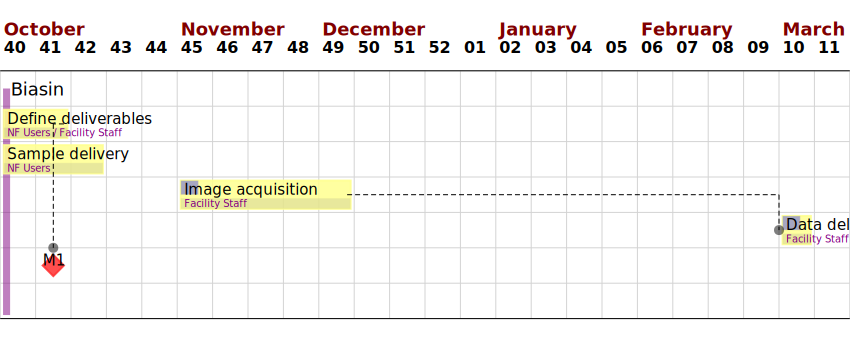

In [8]:
p1.make_svg_for_tasks(filename='test_custom.svg',scale=DRAW_WITH_WEEKLY_SCALE)

In [19]:
p1.change_scaling(0.8)

2025-09-05 10:40:11,835 - WARNING - ** Will draw ressource graph at day scale, not w as requested
2025-09-05 10:40:11,836 - WARNING - ** Due to vacations, Task "Image acquisition", will not start on date 2025-11-01 but 2025-11-03
2025-09-05 10:40:11,837 - WARNING - ** Due to dependencies, Task "Data delivery", will not start on date 2026-03-01 but 2026-03-02
2025-09-05 10:40:11,838 - WARNING - ** Due to dependencies, Task "M1", will not start on date 2025-10-06 but 2025-10-07
2025-09-05 10:40:11,840 - WARNING - ** Resource "NF Users" has more than one task on day 2025-10-01 / ['Define deliverables', 'Sample delivery']
2025-09-05 10:40:11,840 - WARNING - ** Resource "NF Users" has more than one task on day 2025-10-02 / ['Define deliverables', 'Sample delivery']
2025-09-05 10:40:11,841 - WARNING - ** Resource "NF Users" has more than one task on day 2025-10-03 / ['Define deliverables', 'Sample delivery']
2025-09-05 10:40:11,841 - WARNING - ** Resource "NF Users" has more than one task on

NF Users 2
Facility Staff 3


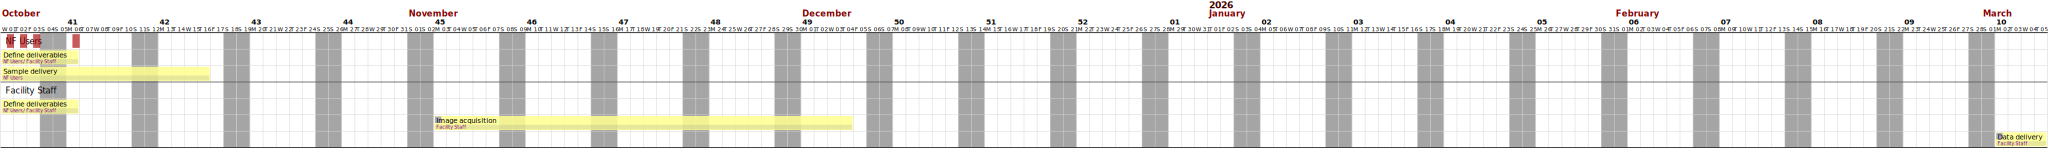

{'conflicts_vacations': [], 'conflicts_tasks': []}

In [20]:
p1.make_svg_for_resources(filename='test_custom_3.svg',scale=DRAW_WITH_WEEKLY_SCALE)